In [14]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [15]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=True, continuous=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [16]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True)

INFO:profiler.utility:[0.42163896560668945] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'None', 'none', '?', 'nan', 'unknown', 'NaN'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operat

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [17]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [18]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[8.309612035751343] Load Embedding start

INFO:profiler.utility:[8.345775842666626] Load Embedding execution time: 0.0361638069152832



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [19]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[8.86588716506958] Create Training Data start

INFO:profiler.transformer:needs multiplier = 214 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 214, and the bound is 0.00006293
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 82.92it/s]
INFO:profiler.transformer:Number of training samples: 227772
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0299
INFO:profiler.utility:[15.441746950149536] Create Training Data execution time: 6.575859785079956



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [20]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, take_neg=False)

INFO:profiler.utility:[15.44712519645691] Learn Structure start

INFO:profiler.learner:use threshold 0.0302
INFO:profiler.utility:[15.490673065185547] Learn Structure execution time: 0.043547868728637695



* score: 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [21]:
parent_sets = pf.session.get_dependencies(score=None)

INFO:profiler.utility:[15.497193098068237] Get Dependencies start

INFO:profiler.utility:[15.51076889038086] Get Dependencies execution time: 0.01357579231262207



Condition -> Stateavg (n/a)
Condition,Stateavg -> MeasureCode (n/a)
ProviderNumber -> HospitalName (n/a)
ProviderNumber,HospitalName -> Address1 (n/a)
MeasureCode,EmergencyService,ProviderNumber,HospitalName,Address1 -> City (n/a)
EmergencyService,ProviderNumber,HospitalName,Address1,City -> CountyName (n/a)
ProviderNumber,HospitalName,Address1,City,CountyName -> HospitalOwner (n/a)
EmergencyService,ProviderNumber,HospitalName,Address1,City,CountyName,HospitalOwner -> PhoneNumber (n/a)


## 5. Visualization

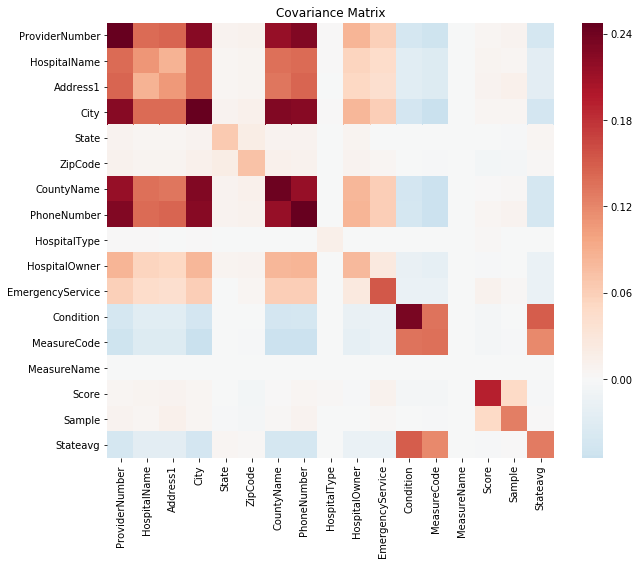

In [22]:
pf.session.visualize_covariance()

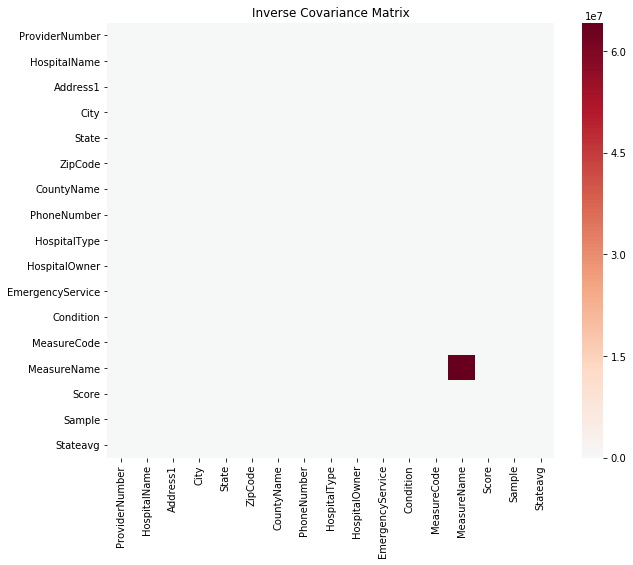

In [23]:
pf.session.visualize_inverse_covariance()

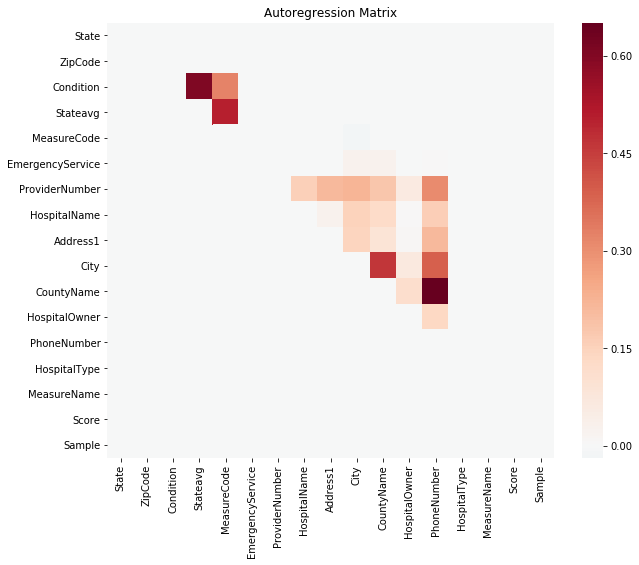

In [24]:
pf.session.visualize_autoregression()

In [25]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.421639,start: Load Data,0.000000
1,0.475403,end: Load Data,0.053764
2,8.309612,start: Load Embedding,0.000000
3,8.345776,end: Load Embedding,0.036164
4,8.865887,start: Create Training Data,0.000000
5,15.441747,end: Create Training Data,6.575860
6,15.447125,start: Learn Structure,0.000000
7,15.490673,end: Learn Structure,0.043548
8,15.497193,start: Get Dependencies,0.000000
9,15.510769,end: Get Dependencies,0.013576
